In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

from keras.models import load_model

Using TensorFlow backend.


# Sanity Check
This is a simple test to see if the model woaks. In order to do that, I will use some easy data to predict. The data came from [this site][1] and the ideia from [this example][2].


Este é um teste para ver se o modelo pensado funciona. Para isso, vou utilizar dados que seguem um padrão muito claro. Os dados foram retirados [deste site][1] e a ideia veio [deste exemplo][2].

[1]: https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line
[2]: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [2]:
look_back = 20
forward_days = 7
num_periods = 4

First, just open the CSV using Pandas and keep the only column that matters.

Primeiro, vamos abrir o CSV com o Pandas manter apenas a coluna que nos interessa.

In [3]:
# available CSVs for this Sanity Check:
# monthly-car-sales-in-quebec-1960.csv
# monthly-lake-erie-levels-1921-19.csv
# monthly-milk-production-pounds-p.csv
# sanity_check.csv

df = pd.read_csv('Data-Sanity/sanity_check.csv', sep=';')

#get the only column that matters
df.set_axis(['a', 'b'], axis='columns', inplace=True)
df = df['b']

df.head()

0    112.0
1    118.0
2    132.0
3    129.0
4    121.0
Name: b, dtype: float64

In [4]:
len(df)

145

### Data visualization  ( Vizualizando os dados )

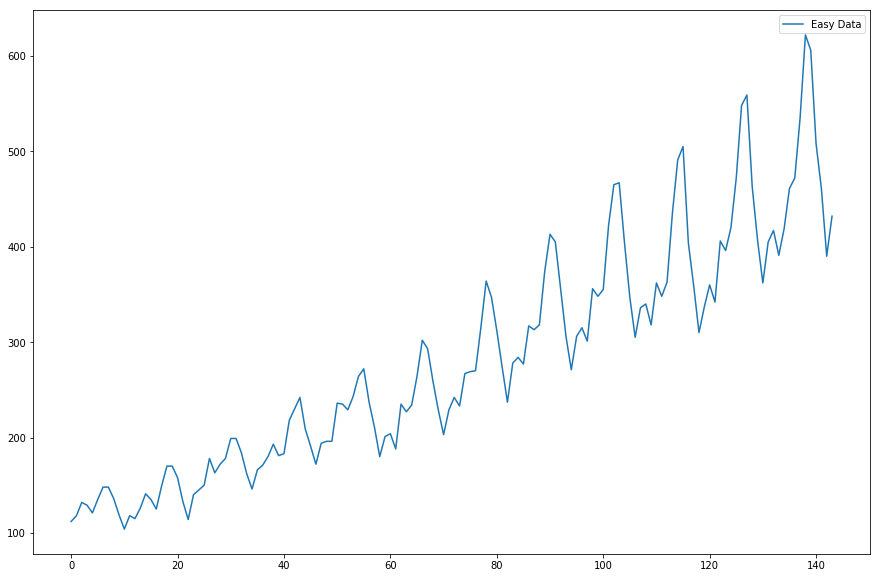

In [5]:
plt.figure(figsize = (15,10))
plt.plot(df, label='Easy Data')
plt.legend(loc='best')
plt.show()

### Data normalization  ( Normalizando os dados )

In [6]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.]])

In [7]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]])

### Split the data in Data to Train/Validate the LSTM and Data to Test the model

The Test set will be the last `k` (`num_periods`) periods we want test the model. In each period, the model will predict the next `n` coming days. The remaning data will be used for Train/Validation.

### ( Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste)
Vamos separar para os últimos `k` períodos (`num_periods`) para testar o modelo. A cada período, o modelo irá prever os próximos `n` dias. O resto será utilizado para o treinamento (Treino e Validação).

In [8]:
#split in Train and Test

division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [9]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [10]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(72, 20, 1)
(19, 20, 1)
(4, 20, 1)
(72, 7)
(19, 7)
(4, 7)


## Training the LSTM (Treinando a LSTM)

In [12]:
#Optionaly, you can load a model, but training a new model is quick in this scenario.
#model = load_model('Trained/Sanity-Check/LSTM_compA_LB40_FD10_E50_F50_S30.h5')

In [13]:
NUM_NEURONS_FirstLayer = 40
NUM_NEURONS_SecondLayer = 20
EPOCHS = 80

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 72 samples, validate on 19 samples
Epoch 1/80
 - 9s - loss: 0.0734 - val_loss: 0.0160
Epoch 2/80
 - 3s - loss: 0.0102 - val_loss: 0.0062
Epoch 3/80
 - 4s - loss: 0.0074 - val_loss: 0.0049
Epoch 4/80
 - 3s - loss: 0.0067 - val_loss: 0.0051
Epoch 5/80
 - 3s - loss: 0.0067 - val_loss: 0.0051
Epoch 6/80
 - 3s - loss: 0.0066 - val_loss: 0.0051
Epoch 7/80
 - 3s - loss: 0.0069 - val_loss: 0.0060
Epoch 8/80
 - 3s - loss: 0.0070 - val_loss: 0.0050
Epoch 9/80
 - 3s - loss: 0.0064 - val_loss: 0.0047
Epoch 10/80
 - 3s - loss: 0.0066 - val_loss: 0.0059
Epoch 11/80
 - 3s - loss: 0.0076 - val_loss: 0.0050
Epoch 12/80
 - 3s - loss: 0.0064 - val_loss: 0.0059
Epoch 13/80
 - 3s - loss: 0.0063 - val_loss: 0.0048
Epoch 14/80
 - 3s - loss: 0.0065 - val_loss: 0.0048
Epoch 15/80
 - 3s - loss: 0.0063 - val_loss: 0.0047
Epoch 16/80
 - 3s - loss: 0.0066 - val_loss: 0.0050
Epoch 17/80
 - 3s - loss: 0.0064 - val_loss: 0.0051
Epoch 18/80
 - 3s - loss: 0.0069 - val_loss: 0.0073
Epoch 19/80
 - 3s - loss: 0.0

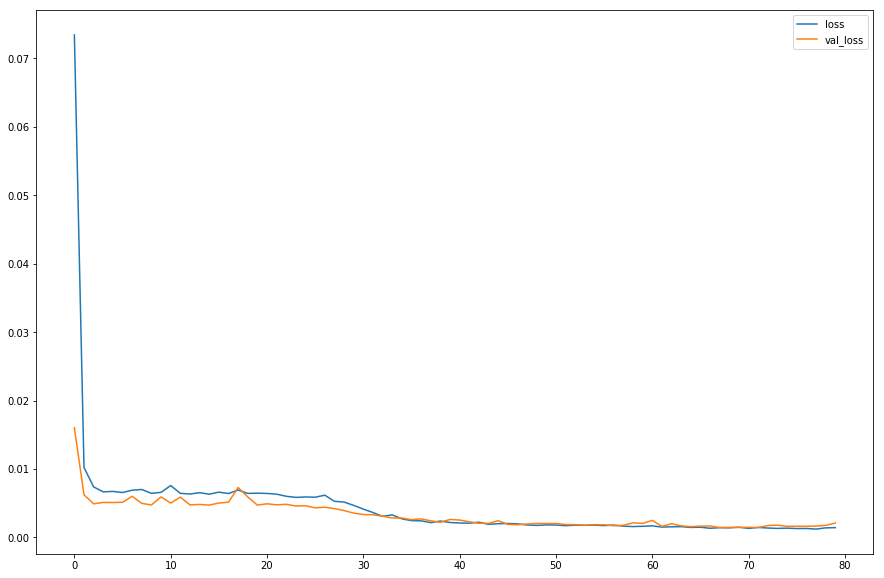

In [14]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [15]:
#Saving the model
file_name = 'Trained/Sanity-Check/LSTM_Sanity_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `Trained/Sanity-Check/LSTM_Sanity_LB20_FD7_E80_F40_S20.h5` to disk


### Predicting the Test Set to see the results  ( Vamos prever os dados de Teste para o resultado )

In [16]:
Xt = model.predict(X_test)

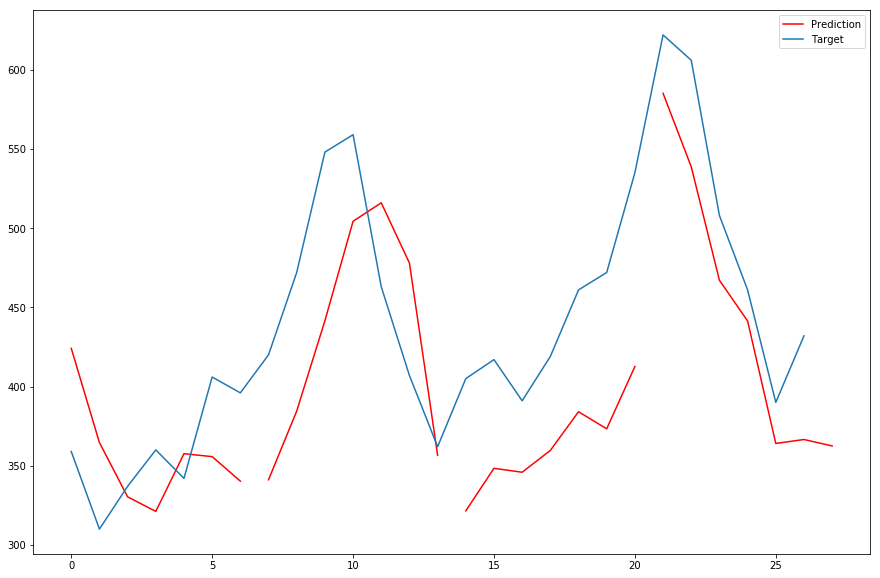

In [17]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

### Predicting all the data to see how the model reacts to Train and Test set
#### (Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste)

In [18]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [19]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [20]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [21]:
y = np.concatenate((ytrain, ytest), axis=0)

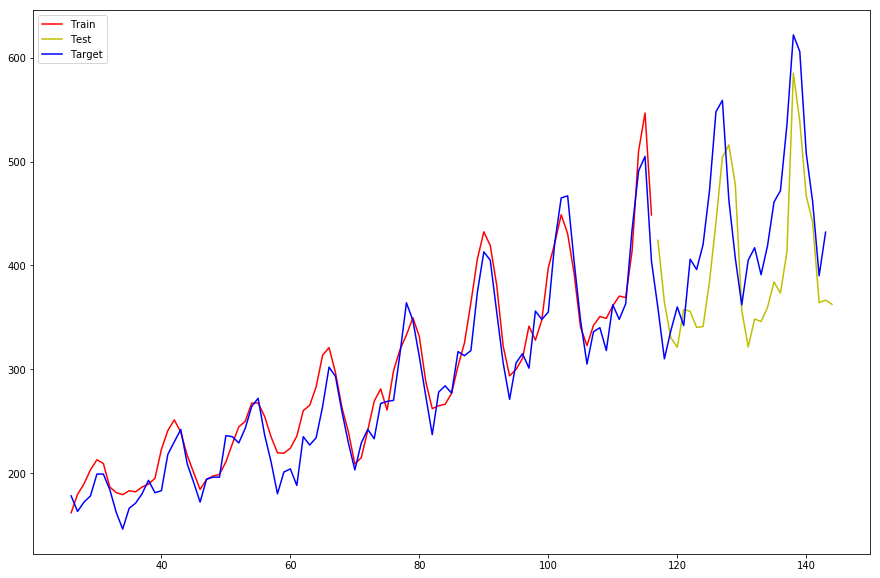

In [22]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()